In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import Wav2Vec2Model
from torch.utils.data import TensorDataset, DataLoader
import copy

In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [165]:
class RandomProjection:
    def __init__(self, input_dim, quantizer_dim, codebook_size, random_state=None, device = 'cpu'):
        self.random_state = random_state
        self.input_dim = input_dim
        self.quantizer_dim = quantizer_dim
        self.codebook_size = codebook_size
        self.projection_matrix = None
        self.codebook = None

    def initialize_quantizer(self):
        # Initialize projection matrix with Xavier initialization
        self.projection_matrix = nn.init.xavier_uniform_(th.empty(self.quantizer_dim, self.input_dim)).to(device)

        # Initialize codebook with standard normal distribution
        self.codebook = nn.init.xavier_normal_(th.empty(self.codebook_size, self.quantizer_dim), gain=1.0).to(device)

    def project(self, X):
        th.manual_seed(self.random_state)

        self.initialize_quantizer()

        #Normalize data
        X_normalized = X / th.norm(X, dim=1, keepdim=True)

        print(self.projection_matrix.shape)

        # Project input data using projection matrix
        X_projected = th.matmul(X_normalized, self.projection_matrix.T)

        return X_projected

    def quantize(self, X):

        X_projected = self.project(X)

        print(X_projected.shape)

        norm_x = th.norm(X_projected, dim = 1)


        codebook = self.codebook.repeat(X_projected.shape[0], 1, 1)

        norm_codebook = th.norm(codebook, dim = 1)

        # Compute distances to codebook vectors
        distances = norm_x - th.transpose(norm_codebook, 0, 1)

        # Find nearest vector index
        labels = th.argmin(distances, dim=0)

        print(norm_x.shape, norm_codebook.shape, distances.shape)

        return labels


class ASREncoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, num_layers=5, dropout=0.1):
        super(ASREncoder, self).__init__()

        # Feature extractor (Wav2Vec2 model)
        self.feature_extractor = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.feature_extractor.freeze_feature_extractor()  # Freeze feature extractor

        # Conformer layers
        conformer_layers = []
        for _ in range(num_layers):
            conformer_layers.append(nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=4,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                activation='gelu'
            ))
        self.conformer_encoder = nn.TransformerEncoder(nn.ModuleList(conformer_layers), num_layers=num_layers)

        # Classifier head
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Extract features using the pre-trained Wav2Vec2 model
        features = self.feature_extractor(x).last_hidden_state

        # Transpose features for Transformer input format (seq_len, batch_size, hidden_dim)
        features = features.permute(1, 0, 2)

        # Apply Conformer layers
        features = self.conformer_encoder(features)

        # Average pooling over time
        pooled_features = torch.mean(features, dim=0)

        # Classification
        output = self.classifier(pooled_features)

        return output

class BESTRq_framework:
    def __init__(self, input_dim, quantizer_dim, num_classes, hidden_dim, batch_size, codebook_size, num_time_steps, mask_prob, door_size):
        self.quantizer = RandomProjection(input_dim, quantizer_dim, codebook_size)
        self.asr_encoder = ASREncoder(quantizer_dim, hidden_dim, num_classes)
        self.loss_function = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.num_time_steps = num_time_steps
        self.mask_prob = mask_prob
        self.door_size = door_size
        self.optimizer = None

    def initialize_optimizer(self, learning_rate):
        self.optimizer = optim.Adam(self.asr_encoder.parameters(), lr=learning_rate)


    def split_batch(self, X, y):
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size= self.batch_size, shuffle=True)
        return data_loader

    def add_noise_and_mask(self, X, noise_mean=0, noise_std=0.1):
        """
        Add noise to masked values in the tensor.

        Args:
        - X (torch.Tensor): Input tensor of shape (n_batch, length).
        - noise_mean (float): Mean of the normal distribution for noise.
        - noise_std (float): Standard deviation of the normal distribution for noise.

        Returns:
        - torch.Tensor: Tensor with masked values replaced by noise.
        """
        n_batch, length = X.shape
        max_start = length - self.door_size + 1
        door_starts = th.randint(0, max_start, (n_batch,))
        mask = th.zeros((n_batch, length), dtype=th.bool)
        idx = th.arange(length)
        mask[th.arange(n_batch)[:, None], door_starts[:, None] + idx[None, :self.door_size]] = True
        mask = mask & (th.rand((n_batch, length)) < self.mask_prob)
        noise = th.normal(mean=noise_mean, std=noise_std, size=(n_batch, length))
        masked_X = th.clone(X)
        masked_X[mask] = noise[mask]
        return masked_X



    def pretrain(self, xtrain, ytrain, xvalid, yvalid, epochs=10, batch_size=32):
        # Initialize quantizer
        self.quantizer.initialize_quantizer()
        trainloader = self.splitbatch(xtrain, ytrain)
        validloader = self.splitbatch(xvalid, yvalid)

        # Iterate over epochs
        for epoch in range(epochs):
            epoch_loss = 0.0

            for inputs, labels in trainloader:

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                labels = self.quantizer.quantize(inputs)
                predictions = self.asr_encoder(labels)

                # Compute loss
                loss = self.loss_function(predictions, labels)

                # Backward pass
                loss.backward()

                # Update weights
                self.optimizer.step()

                epoch_loss += loss.item()

            # Print epoch loss
            print(f"Pretraining Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(X_tensor)}")


In [65]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0]

600

In [178]:
tmp = RandomProjection(input_dim= 600, quantizer_dim= 100, codebook_size= 20,random_state= 2673834267383, device = device)
tmp.quantize(xtrain.to(device))

torch.Size([100, 600])
torch.Size([175995, 100])
torch.Size([175995]) torch.Size([175995, 100]) torch.Size([100, 175995])


tensor([81, 81, 81,  ..., 81, 81, 81], device='mps:0')

In [103]:
tmp = RandomProjection(input_dim= 600, quantizer_dim= 500, codebook_size= 1000,random_state= 16722)
tmp.quantize(xtrain[:300])

tensor([467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467,
        467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 4

In [42]:
test = SelfSupervisedRandomProjectionQuantizer(input_dim= 600, quantizer_dim = 100, hidden_dim= 10, num_classes=5, batch_size=200, codebook_size= 100)

NameError: name 'SelfSupervisedRandomProjectionQuantizer' is not defined

In [88]:
mini_batchs = test.split_batch(xtrain, ytrain)
mini_batchs


In [166]:
#### Test for Masking

BestRq = BESTRq_framework(input_dim = 600, quantizer_dim= 100, num_classes=5, hidden_dim= 4, batch_size = 10, codebook_size= 15, num_time_steps= 30, mask_prob= 0.7, door_size = 100)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/constouille/Library/Caches/pypoetry/virtualenvs/dl-sleep-project-wfnrCJ-y-py3.10/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1471: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(
/Users/constouille/Library/Caches/pypoetry/virtualenvs/dl-sleep-project-wfnrCJ-y-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_n

In [180]:
noisy_signal = BestRq.add_noise_and_mask(xtrain[:100])

In [158]:
xtrain.maske

AttributeError: 'Tensor' object has no attribute 'masked'

In [122]:
(xtrain[:3] == noisy_signal).sum()


tensor(1797)

In [177]:
noisy_signal

tensor([[ -2.6508,  -6.7729,  -4.7118,  ...,  -6.7729,  -8.3187,  -6.2576],
        [-23.7766, -27.8987,  25.1734,  ...,  -2.6508, -26.8681, -22.7460],
        [-12.4408, -31.5055, -13.4713,  ...,   7.1392,   7.6545,   2.5018]])

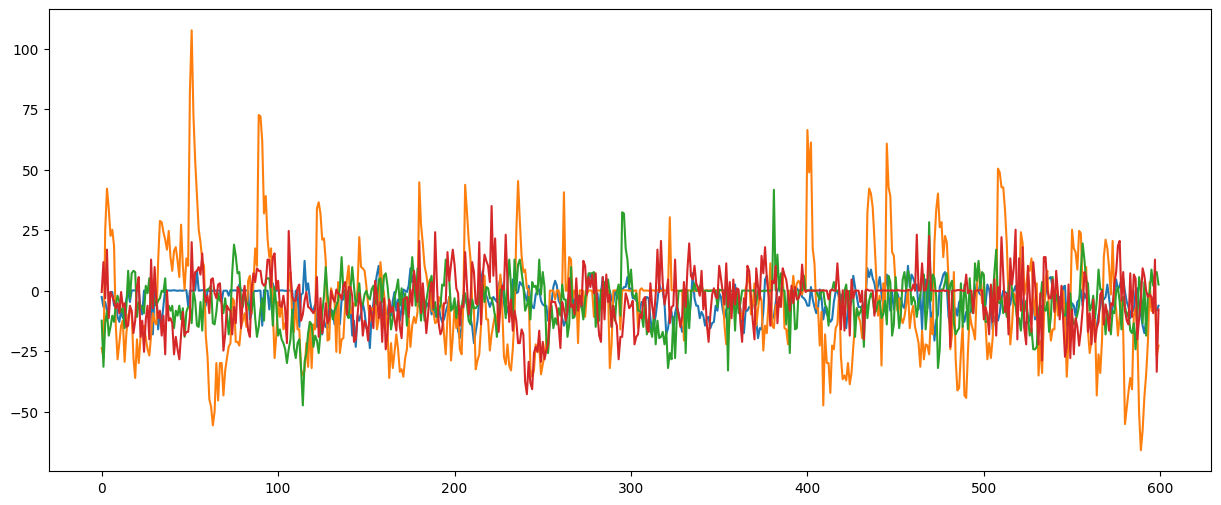

In [190]:
plt.figure(figsize=(15,6))
for i in range(4):
    plt.plot(noisy_signal[i])


In [191]:
tmp.quantize(noisy_signal.to(device))

torch.Size([100, 600])
torch.Size([100, 100])
torch.Size([100]) torch.Size([100, 100]) torch.Size([100, 100])


tensor([81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81], device='mps:0')

In [53]:
input_lengths

tensor([ -2.6508,  -0.5897, -10.3797,   1.9866, -12.4408,  35.9939,  -0.5897,
        -49.5397, -16.0476, -11.9255])

In [7]:
xtrain, ytrain

(tensor([[ -2.6508,  -6.7729,  -4.7118,  ...,  -6.7729,  -8.3187,  -6.2576],
         [-23.7766, -27.8987,  25.1734,  ...,  -2.6508, -26.8681, -22.7460],
         [-12.4408, -31.5055, -13.4713,  ...,   7.1392,   7.6545,   2.5018],
         ...,
         [ 20.3521,  15.5853,  38.9426,  ...,  30.3624,  29.4090,  30.8391],
         [ 13.2020,   8.4352,   7.0051,  ...,  -4.9118,  -2.0518,  -4.9118],
         [-21.1189, -12.5387, -20.1656,  ...,  -4.4352,  -1.5751,  -0.1451]]),
 tensor([2, 0, 0,  ..., 0, 2, 2], dtype=torch.int32))